<a href="https://colab.research.google.com/github/yassmin1/Deep_Learning/blob/main/Rock_tranlearning_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rocks Classification
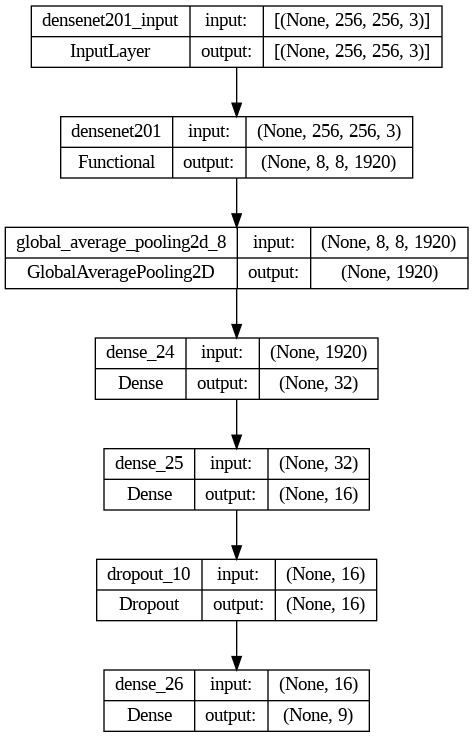

# Problem Statement
In the field of geology, there's a growing need for automated rock classification systems. These systems should be capable of analyzing rock samples based on their visual attributes, offering a quicker and more precise alternative to manual classification methods. To address this, we aim to create a Convolution neural network model that can classify various rock types accurately. Our dataset comprises thousands of high-resolution rock images, each labeled with its respective rock type.

### Objective

The primary objective is to develop a reliable neural network that can classify these rock samples into specific geological categories, thereby facilitating geological research, resource exploration, and rock identification processes.

#### Dataset containing
* A dataset of approximately 700 textural images was generated from these 9 different types of
rocks.
* There are roughly 80 images in total for each type of rock. Each image has size 128 ×128 ×3 pixels and is between 1 and 2 cm across in reality.
* the classes: rhyolite, volcanic breccia, limestone, granite, andesite, oolitic
limestone, red granite, peridotite, dolostone

*  Rock images in array format
* Consists of two main folders: images, and labels

    

## Importing necessary libraries

In [104]:

import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential,Model                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [3]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Load the image file of dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/DL_ComputerImaging/rock_classification/texture_dataset/images.npy',allow_pickle=True)      # Complete the code to read the dataset

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL_ComputerImaging/rock_classification/texture_dataset/labels.csv',index_col=0)

## Data Overview

### Understand the shape of the dataset

In [5]:
print(images.shape)         # Complete the code to check the shape
print(labels.shape)         # Complete the code to check the shape

(128, 128, 3, 711)
(711, 1)


## Exploratory Data Analysis

### Plotting random images from each of the class

In [6]:
def plot_images(images,labels,num_classes=9):
                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))
                                                # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[:,:,:,random_index])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

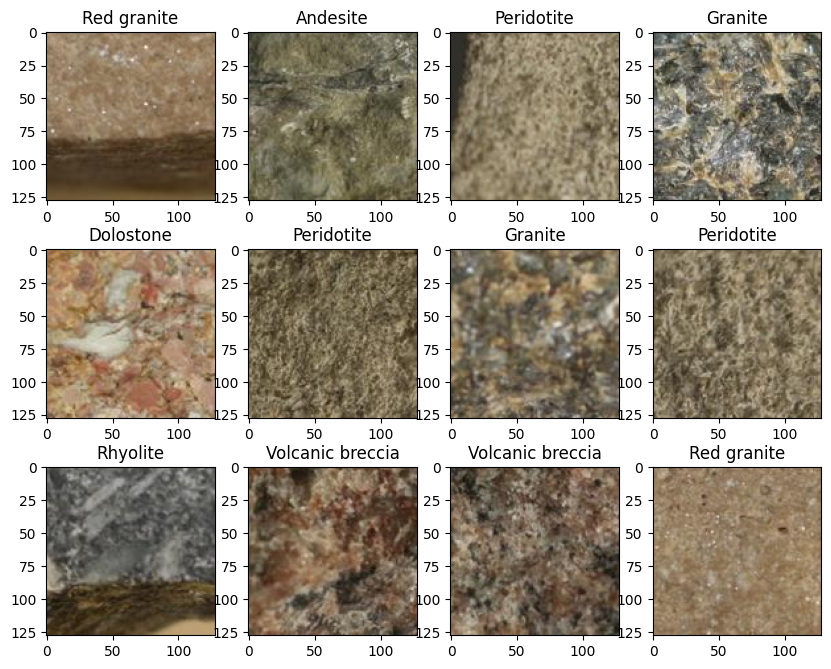

In [7]:
plot_images(images,labels)   # Complete the code to input the images and labels to the function and plot the images with their labels

### Checking the distribution of the target variable

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100')])

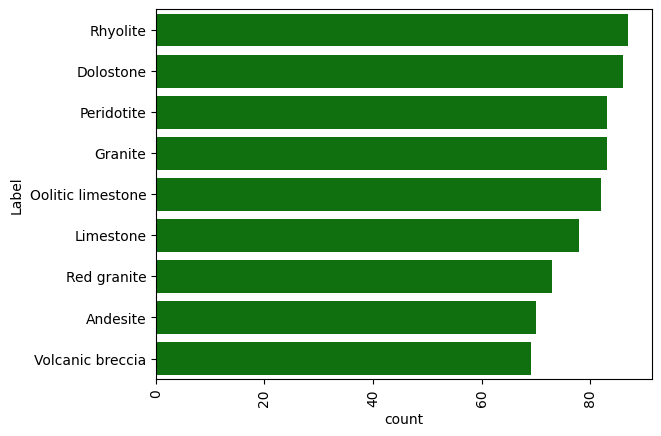

In [8]:
sns.countplot(y=labels['Label'],color='green',order=labels['Label'].value_counts().reset_index()['index'].tolist())            # Complete the code to check for data imbalance
plt.xticks(rotation='vertical')

Text(0.5, 1.0, 'Rock classes')

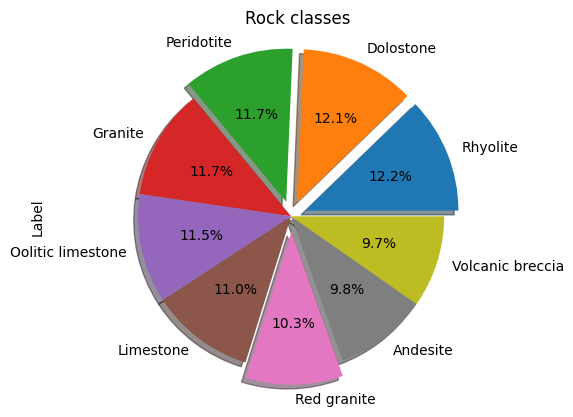

In [9]:
labels['Label'].value_counts().plot.pie(y='Label', autopct='%1.1f%%',
                 legend=False,
                    explode=(0.1,0.1,0.1,0,0,0,0.1,0,0),
                   shadow=True, startangle=0)

plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

plt.title('Rock classes')


## Data Pre-Processing

### Converting the BGR images to RGB images.

### Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [10]:
images.shape[3]

711

In [11]:
print(images.shape)

images_decreased=[]
height = 256
width =  256
dimensions = (width, height)
for i in range(images.shape[3]):
  #print(i)
  try:
    images_decreased.append( cv2.resize(images[:,:,:,i], dimensions, interpolation=cv2.INTER_LINEAR))
  except:
    print(i)



(128, 128, 3, 711)


In [12]:
print(images_decreased[0].shape)

(256, 256, 3)


In [13]:
len(images_decreased),images.shape[3]


(711, 711)

**Image before resizing**

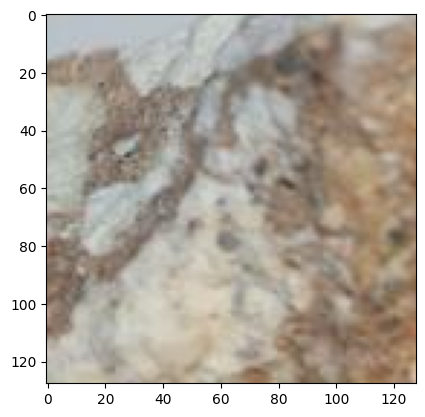

In [14]:
plt.imshow(images[:,:,:,5])

**Image after resizing**

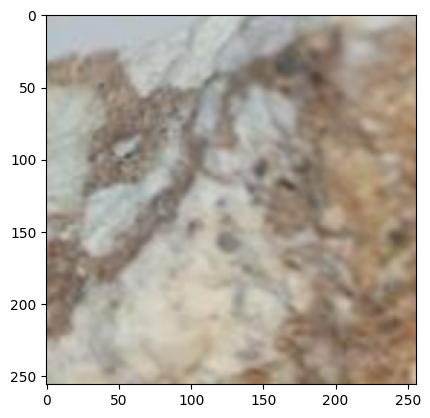

In [15]:
plt.imshow(images_decreased[5])

### Data Preparation for Modeling


- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [16]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)   # Complete the code to split the data with test_size as 0.1
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)                       # Complete the code to split the data with test_size as 0.1

In [17]:
# Complete the code to check the shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(575, 256, 256, 3) (575, 1)
(64, 256, 256, 3) (575, 1)
(72, 256, 256, 3) (72, 1)


### Encoding the target labels

In [18]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

enc = LabelBinarizer()                                    # Complete the code to intialize the labelBinarizer
y_train_encoded = enc.fit_transform(y_train)        # Complete the code to fit and transform y_train
y_val_encoded=enc.transform(y_val)                  # Complete the code to transform y_val
y_test_encoded=enc.transform(y_test)                # Complete the code to transform y_test

In [19]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape    # Complete the code to check the shape of train, validation and test data

((575, 9), (64, 9), (72, 9))

In [20]:
y_train.Label[:].count()

575

### Data Normalization

In [21]:
#check if the images was normalized before or not :
images_decreased[5].min(),images_decreased[5].max()

(0.20882353, 0.8754902)

## image preprocessing to understand the images

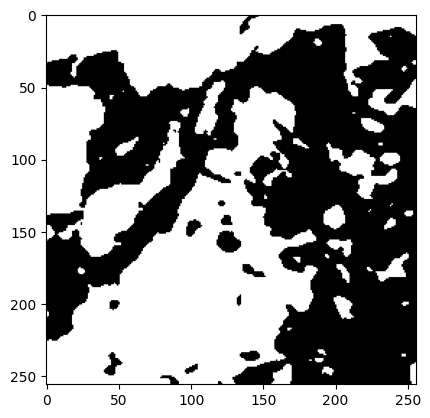

In [22]:
# Import threshold and gray convertor functions
from skimage.filters import threshold_local,try_all_threshold,threshold_otsu,gaussian
from skimage.color import rgb2gray
tools_image=images_decreased[5]

# Turn the image grayscale
gray_tools_image = rgb2gray(tools_image)
gua_image=gaussian(tools_image)
# Obtain the optimal thresh
thresh = threshold_otsu(gray_tools_image)

# Obtain the binary image by applying thresholding
binary_image = gray_tools_image > thresh

# Show the resulting binary image
plt.imshow(binary_image,cmap='gray')
#plt.imshow(gua_image,cmap='gray')

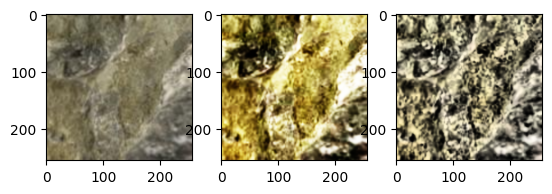

In [23]:
# Import the required module
from skimage import exposure

# Use histogram equalization to improve the contrast
image_eq =  exposure.equalize_hist(X_train[100])

# Show the original and resulting image
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(X_train[100])
ax2.imshow(image_eq)
adapthist_eq_image = exposure.equalize_adapthist(X_train[100], clip_limit=0.03)
ax3.imshow(adapthist_eq_image)

In [24]:
from PIL import Image
def myFunc_brit(image):
    image = np.array(image)
    im=tf.image.adjust_brightness(cv2.cvtColor((image*255).astype(np.uint8),cv2.COLOR_RGB2HSV),0.1)
    return im/255
def myFunc_sat(image):
    image = np.array(image)
    im=tf.image.adjust_saturation(cv2.cvtColor((image*255).astype(np.uint8),cv2.COLOR_RGB2HSV),0.9)
    return im/255

# Models Building

## Transfer Learning with Data Agumentation
We will be loading a pre-built architecture - VGG16, which was trained on the ImageNet dataset and finished runner-up in the ImageNet competition in 2014. Below is a schematic of the VGG16 model.

For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. We will remove the already-present fully-connected layers and add our own fully-connected layers for this binary classification task.

In [43]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet201
from keras.applications.inception_resnet_v2 import InceptionResNetV2
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.00001)


In [44]:
# Clearing backend
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [45]:
# Loading DenseNet model
vgg_model = DenseNet201(weights='imagenet', include_top = False, input_shape = (height,width,3))


In [46]:
vgg_model.summary()#get_layer('block5_pool')

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']

In [47]:
vgg_model.layers

In [60]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers[:]:
    layer.trainable = False
#for layer in vgg_model.layers[-4:]:
#     layer.trainable = True

In [112]:
# Initializing the model
new_model = Sequential()
# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)
new_model.add(GlobalAveragePooling2D())
# Adding a fully connected dense layer with 16 neurons
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(16, activation='relu'))
# Complete the code to add dropout with dropout_rate=0.1
new_model.add(Dropout(0.3))
# Complete the code to add the output layer with 7 neurons and activation functions as softmax since this is a multi-class classification problem
new_model.add(Dense(9, activation='softmax'))




In [113]:
# Compiling the model
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
# Summary of the model
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d_8  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_24 (Dense)            (None, 32)                61472     
                                                                 
 dense_25 (Dense)            (None, 16)                528       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_26 (Dense)            (None, 9)                 153       
                                                      

In [114]:
train_datagen = ImageDataGenerator(
                              rotation_range=50,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.2,
    #horizontal_flip=True,
                              #preprocessing_function = myFunc,

                              fill_mode='nearest'
                              )
# Epochs
epochs = 30
# Batch size
batch_size =64
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = new_model.fit(train_datagen.flow(X_train,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train.shape[0] // batch_size,
                                       validation_data=(X_val,y_val_encoded),
                                       verbose=1,
                        callbacks=[learning_rate_reduction,early_stopping]
                        )

Epoch 1/30
8/8 [==============================] - 27s 2s/step - loss: 2.2948 - accuracy: 0.1367 - val_loss: 2.0362 - val_accuracy: 0.3125 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - 9s 1s/step - loss: 2.0014 - accuracy: 0.2740 - val_loss: 1.9241 - val_accuracy: 0.3281 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - 10s 1s/step - loss: 1.8032 - accuracy: 0.3379 - val_loss: 1.4572 - val_accuracy: 0.6406 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - 10s 1s/step - loss: 1.4374 - accuracy: 0.4971 - val_loss: 1.0411 - val_accuracy: 0.7188 - lr: 0.0100
Epoch 5/30
8/8 [==============================] - 9s 1s/step - loss: 1.1746 - accuracy: 0.5890 - val_loss: 0.8159 - val_accuracy: 0.7812 - lr: 0.0100
Epoch 6/30
8/8 [==============================] - 10s 1s/step - loss: 1.0200 - accuracy: 0.6184 - val_loss: 0.6315 - val_accuracy: 0.8438 - lr: 0.0100
Epoch 7/30
8/8 [==============================] - 10s 1s/step - loss: 0.8948 - accuracy: 0.6497 

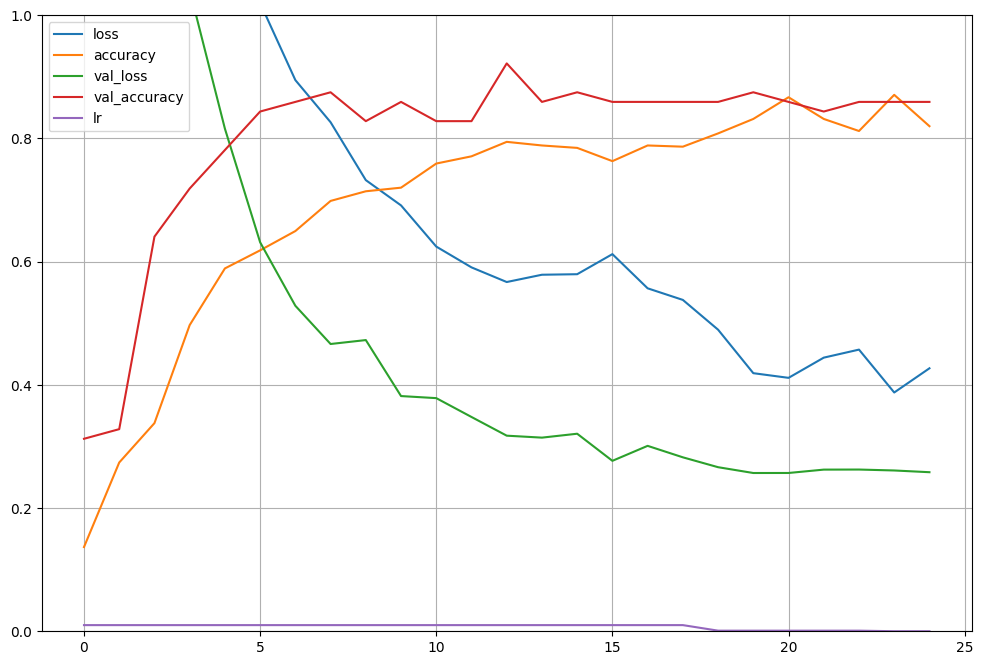

In [129]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


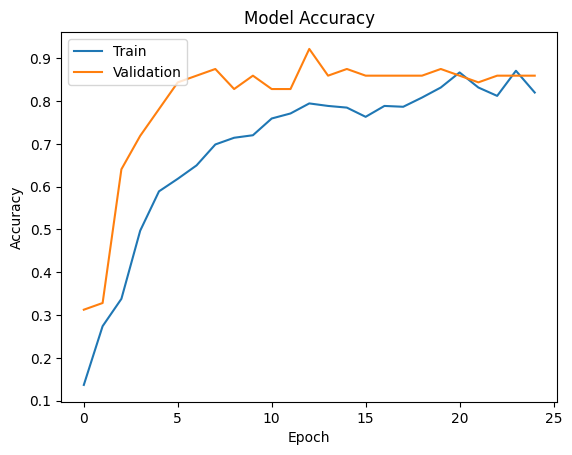

In [115]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

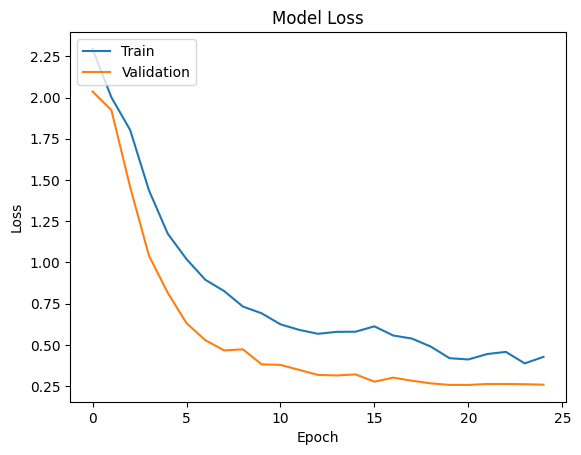

In [126]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [117]:
accuracy = new_model.evaluate(X_test, y_test_encoded, verbose=2)  # Complete the code to evaluate the model on test data

3/3 - 4s - loss: 0.1587 - accuracy: 0.9722 - 4s/epoch - 1s/step


In [118]:
# Complete the code to obtain the output probabilities
y_pred_model=new_model.predict(X_test)

3/3 [==============================] - 4s 206ms/step


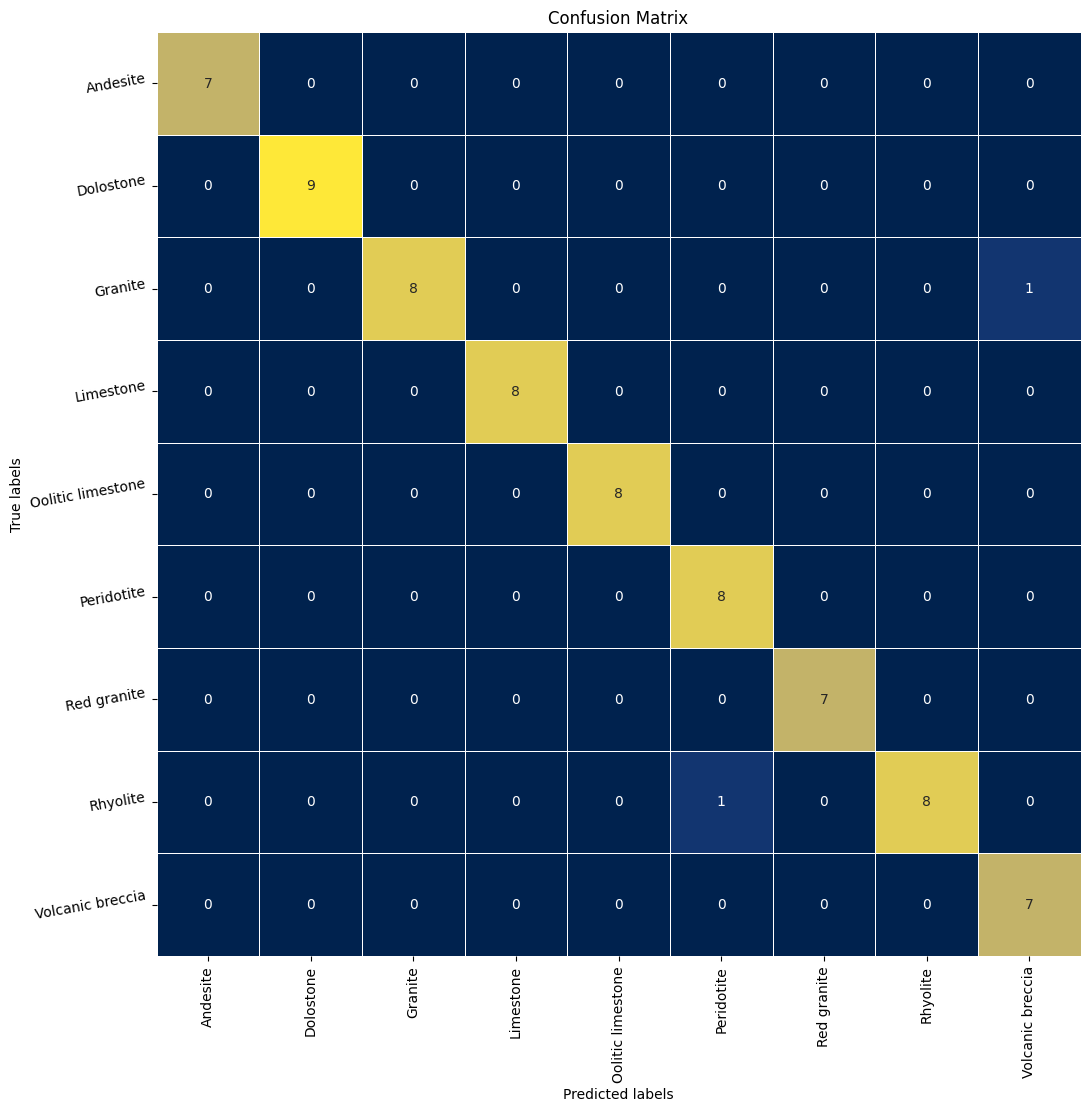

In [128]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred_model,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,cmap='cividis',
    ax=ax,cbar=False
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=10)
plt.show()

In [120]:
from sklearn import metrics
cr=metrics.classification_report(y_test_arg,y_pred_arg,target_names=enc.classes_,output_dict=False)     # Complete the code to plot the classification report
print(cr)

                   precision    recall  f1-score   support

         Andesite       1.00      1.00      1.00         7
        Dolostone       1.00      1.00      1.00         9
          Granite       1.00      0.89      0.94         9
        Limestone       1.00      1.00      1.00         8
Oolitic limestone       1.00      1.00      1.00         8
       Peridotite       0.89      1.00      0.94         8
      Red granite       1.00      1.00      1.00         7
         Rhyolite       1.00      0.89      0.94         9
 Volcanic breccia       0.88      1.00      0.93         7

         accuracy                           0.97        72
        macro avg       0.97      0.98      0.97        72
     weighted avg       0.98      0.97      0.97        72



# Visualizing the prediction

In [132]:
false_prediction_indices = np.where(y_pred_arg != y_test_arg)[0]
print(f"false prediction indeces:{false_prediction_indices}")

false prediction indeces:[36 41]


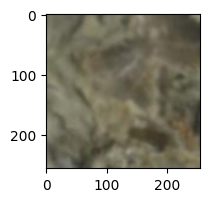

1/1 [==============================] - 0s 67ms/step
Predicted Label ['Andesite']
True Label Andesite


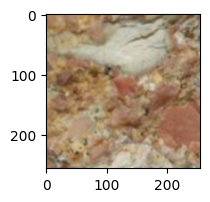

1/1 [==============================] - 0s 59ms/step
Predicted Label ['Dolostone']
True Label Dolostone


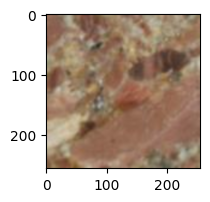

1/1 [==============================] - 0s 71ms/step
Predicted Label ['Dolostone']
True Label Dolostone


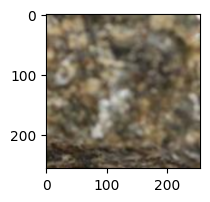

1/1 [==============================] - 0s 65ms/step
Predicted Label ['Volcanic breccia']
True Label Granite


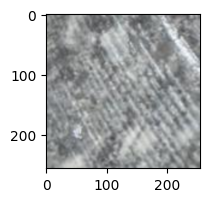

1/1 [==============================] - 0s 78ms/step
Predicted Label ['Peridotite']
True Label Rhyolite


In [134]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
dim=(1,height,width,3)
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test[2].reshape(dim)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test[33].reshape(dim)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test[59].reshape(dim)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test[36].reshape(dim)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])
                                           # using inverse_transform() to get the output label from the output vector
plt.figure(figsize=(2,2))
plt.imshow(X_test[41])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test[41].reshape(dim)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[41])


In [122]:
from tensorflow.keras.utils import plot_model

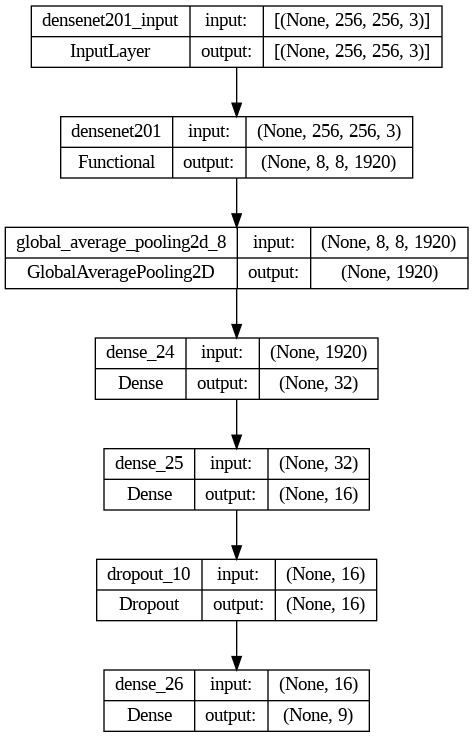

In [123]:
plot_model(new_model, to_file='model1.png', show_shapes=True, show_layer_names=True)

In [124]:
!pip install visualkeras
import visualkeras
from PIL import ImageFont


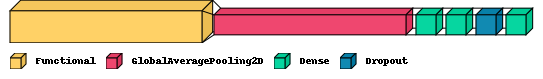

In [125]:
visualkeras.layered_view(new_model, legend=True, spacing=10)

_____

## INSIGHTS:
The predictive models achieve an impressive accuracy of 0.97, with most of the classes exhibiting F1 scores exceeding 0.9. It's important to note that the high accuracy may, in part, be attributed to the relatively small size of the test dataset.
* next step: Enhance the dataset by including more examples and introducing variations.